# Data Exploration

The objective of this notebook is to get a sense of the decline in customer retention rates and prepare the data for machine learning. 

### Load the data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()


Now we'll read our dataset with pandas:

In [2]:
# Read data
data = pd.read_csv("../data/data.csv")
data.head(5)

,ID,Subscription,Refill,Interval,Price per interval,PaymentMethod,CodeUsed,Country,Quantity,Products,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,StopReason,StopReasonExtraMessage,Active
0,2092329948149575290,1,0,3,5.0,ideal,0,Nederland,1,Brush,1,54.0,217,217,NaN,NaN,0
1,12849545117712085541,1,0,2,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0
2,8144808881881603173,1,0,2,5.0,ideal,0,Nederland,1,Brush,1,69.0,66,66,NaN,NaN,0
3,14457143150027122736,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0
4,9143720643862541019,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0


Let's start by looking at the shape of our data and the column types.

In [3]:
# Print shape of data
print(data.shape)

(945, 17)


In [4]:
# Check data types
data.dtypes

ID                         uint64
Subscription                int64
Refill                      int64
Interval                    int64
Price per interval        float64
PaymentMethod              object
CodeUsed                    int64
Country                    object
Quantity                    int64
Products                   object
Transactions                int64
Revenue                   float64
DaysSinceLastOrder          int64
SubscriptionLifetime        int64
StopReason                 object
StopReasonExtraMessage     object
Active                      int64
dtype: object

Notice that ID should not an integer but a string. Let's convert that variable.

In [5]:
# Change data types
data["ID"] = data["ID"].astype(str)

data.dtypes

ID                         object
Subscription                int64
Refill                      int64
Interval                    int64
Price per interval        float64
PaymentMethod              object
CodeUsed                    int64
Country                    object
Quantity                    int64
Products                   object
Transactions                int64
Revenue                   float64
DaysSinceLastOrder          int64
SubscriptionLifetime        int64
StopReason                 object
StopReasonExtraMessage     object
Active                      int64
dtype: object

We should also look at the summary statistics for all the numeric columns using the describe function.

In [6]:
# Show statistics on the current data 
data.describe()

,Subscription,Refill,Interval,Price per interval,CodeUsed,Quantity,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,Active
count,945.000000,945.000000,945.000000,945.000000,945.0,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,0.951323,0.008466,2.815873,5.862434,0.0,1.266667,1.097354,71.877725,93.119577,93.554497,0.053968
std,0.215306,0.091667,0.409063,1.903976,0.0,0.877448,0.372582,38.947608,46.214215,46.711378,0.226075
min,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,13.800000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,3.000000,5.000000,0.0,1.000000,1.000000,49.000000,64.000000,64.000000,0.000000
50%,1.000000,0.000000,3.000000,5.000000,0.0,1.000000,1.000000,59.000000,83.000000,83.000000,0.000000
75%,1.000000,0.000000,3.000000,5.000000,0.0,1.000000,1.000000,69.000000,104.000000,104.000000,0.000000
max,1.000000,1.000000,3.000000,10.000000,0.0,13.000000,5.000000,523.000000,255.000000,255.000000,1.000000


In [7]:
# Check for na or missing data
data.isna().sum()

ID                          0
Subscription                0
Refill                      0
Interval                    0
Price per interval          0
PaymentMethod               1
CodeUsed                    0
Country                     0
Quantity                    0
Products                    0
Transactions                0
Revenue                     0
DaysSinceLastOrder          0
SubscriptionLifetime        0
StopReason                927
StopReasonExtraMessage    943
Active                      0
dtype: int64

## Exploring the Variables

Since we intend to predict the active variable, we will start with this variable.

In [8]:
# Check active vs inactive customers
data["Active"].value_counts()

0    894
1     51
Name: Active, dtype: int64

We can evaluate the percent of projects in each group as well by setting normalize to True in the function.

In [9]:
# Check active percentage
data["Active"].value_counts(normalize=True)

0    0.946032
1    0.053968
Name: Active, dtype: float64

It seems that about 5% of all customers have unsubscribed (became inactive). The rest of the customers are still subscribed.

Now let's look at the number of purchases per customer:

In [10]:
# The number of times a customer repurchased
data["Transactions"].value_counts()

1    871
2     61
3      9
4      3
5      1
Name: Transactions, dtype: int64

In [11]:
# The number of times a customer repurchased in percentages
data["Transactions"].value_counts(normalize=True)

1    0.921693
2    0.064550
3    0.009524
4    0.003175
5    0.001058
Name: Transactions, dtype: float64

As you can see above, 92% only bought once. This makes sense, because the data ranges from a short period of time (2019-10-21 to 2020-07-01).

In [12]:
# How many products have been sold per customer?
data["Products"].value_counts()

Brush     892
Heads      44
Cables      9
Name: Products, dtype: int64

In [13]:
# Where do the customers come from?
data["Country"].value_counts()

Nederland      938
België           4
Germany          2
Switzerland      1
Name: Country, dtype: int64

### How many customers cancel their subscription within 7 days? Why?

**SubscriptionLifetimeBin**
* `Short`: 1 to 85 days
* `Medium`: 86 to 170 days
* `Long`: 171 to 255 days

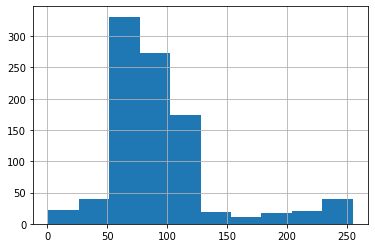

In [14]:
data["SubscriptionLifetime"].hist()

In [15]:
# Binning subscription lifetime
labels = ["Low","Medium","High"]
cutoff = [0,60,120,365]
data["SubscriptionLifetimeBin"] = pd.cut(data["SubscriptionLifetime"],cutoff,labels=labels)
data["SubscriptionLifetimeBin"].value_counts()

Medium    650
Low       172
High      123
Name: SubscriptionLifetimeBin, dtype: int64

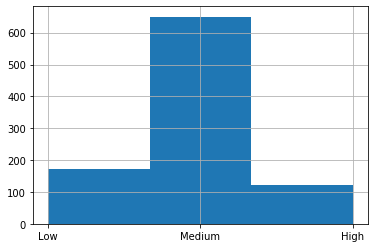

In [16]:
# test = data[data["SubscriptionLifetimeBin"]=="High"]
data["SubscriptionLifetimeBin"].sort_values(ascending=True).hist(bins=3)

In [17]:
data["SubscriptionLifetimeBin"].value_counts(normalize=True)

Medium    0.687831
Low       0.182011
High      0.130159
Name: SubscriptionLifetimeBin, dtype: float64

This data shows that almost 20% of total customers are subscribed for 60 days.

Now let's find out why customers become inactive (unsubscribe).

In [18]:
data["StopReason"].value_counts()

Ik heb nog borstelkopjes             9
Ik gebruik de borsel niet meer.      4
Other                                2
Ik vind het product niet prettig.    2
I still have brush heads left.       1
Name: StopReason, dtype: int64

In [19]:
data["StopReasonExtraMessage"].value_counts()

werkt dit eigenlijk?    1
ik bestel ze zelf       1
Name: StopReasonExtraMessage, dtype: int64

In [20]:
data[data["Active"]==0]

,ID,Subscription,Refill,Interval,Price per interval,PaymentMethod,CodeUsed,Country,Quantity,Products,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,StopReason,StopReasonExtraMessage,Active,SubscriptionLifetimeBin
0,2092329948149575290,1,0,3,5.0,ideal,0,Nederland,1,Brush,1,54.0,217,217,NaN,NaN,0,High
1,12849545117712085541,1,0,2,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0,Medium
2,8144808881881603173,1,0,2,5.0,ideal,0,Nederland,1,Brush,1,69.0,66,66,NaN,NaN,0,Medium
3,14457143150027122736,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0,Medium
4,9143720643862541019,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,12976144141776893305,1,0,1,5.0,ideal,0,Nederland,1,Brush,1,79.0,67,67,NaN,NaN,0,Medium
941,3268560322686142709,1,0,3,5.0,ideal,0,Nederland,1,Brush,1,79.0,67,67,NaN,NaN,0,Medium
942,15074063836055875062,1,0,3,5.0,ideal,0,Nederland,1,Brush,1,79.0,67,67,NaN,NaN,0,Medium
943,5322434471778858021,1,0,3,10.0,ideal,0,Nederland,2,Brush,2,108.0,61,66,NaN,NaN,0,Medium


In [21]:
cancelwithin7days = data[(data["SubscriptionLifetime"]<8)&(data["Active"]==0)]
cancelwithin7days[["Subscription","StopReason","StopReasonExtraMessage"]]

,Subscription,StopReason,StopReasonExtraMessage
269,0,NaN,NaN
270,0,NaN,NaN
272,0,NaN,NaN
273,0,NaN,NaN
274,0,NaN,NaN
608,0,NaN,NaN


The data shows that most people (10 customers) cancel their subscriptions because they still have toothbrush heads left. Fewer customers (4 customers) cancel because they do not use the tootbrush anymore and some don't like the product (2 customers). In addition, one customer added they wanted to order the heads themselves, suggesting they like to be in control.

### Is there a relation between the length of the subscription and the stopreason?

In [22]:
stopreason = data[data["StopReason"].isna()==False]
# stopreason[["SubscriptionLifetime","StopReason"]].sort_values(by="SubscriptionLifetime")

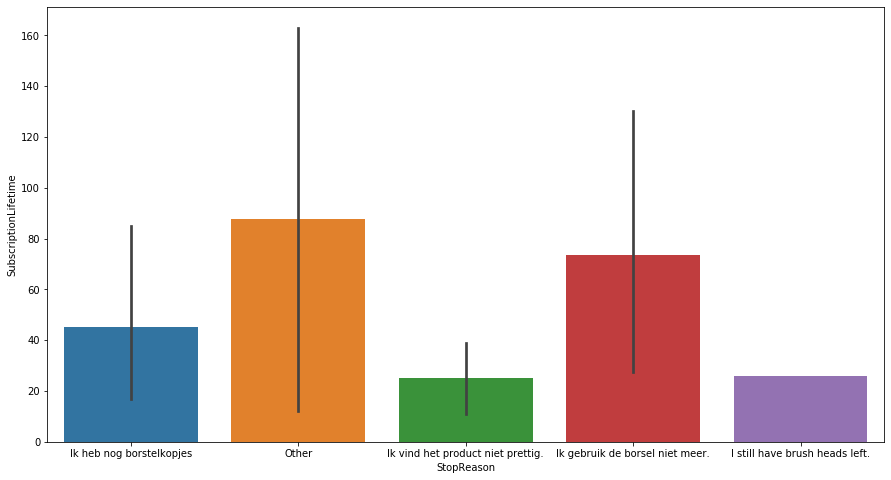

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
barchart = sns.barplot(x="StopReason",y="SubscriptionLifetime",data=stopreason)

Based on the presented data, there doesn't seem to be a relationship between SubscriptionLifetime and StopReason. More data is necessary to further research this relationship.

We can use the crosstab function to see how active vs inactive is divided across different product types. We will also add the success rate for each product type.

In [24]:
# Check active vs inactive customers
data["Active"].value_counts()

0    894
1     51
Name: Active, dtype: int64

In [25]:
producttype_active = pd.crosstab(data["Products"],data["Active"])
producttype_active
producttype_active["Active_rate"] = producttype_active[1]/(producttype_active[1]+producttype_active[0])
producttype_active

Active,0,1,Active_rate
Products,,,
Brush,843,49,0.054933
Cables,9,0,0.000000
Heads,42,2,0.045455


As there is few data of inactive customers, it is not clear which product type seem to have less inactive customers. It seems our data is imbalanced, therefore we will fix this with techniques to handle imbalanced data in the notebook for data prediction.

## Survival Analysis
"Survival Analysis is a set of statistical tools, which addresses questions such as ‘how long would it be, before a particular event occurs’; in other words we can also call it as a ‘time to event’ analys

With the help of Survival Analysis we can focus on inactive customer prevention efforts of high-value customers with low survival time. This analysis also helps us to calculate Customer Life Time Value.
* **Event** is defined as the time at which the customer churns / unsubscribe / becomes inactive.
* **Time of origin** is defined as the time at which the customer starts the service/subscription with a company. 
* **Time scale** could be months, or weeks. The difference between the time of event and the time origin gives us the time to event."

* [Survival Analysis](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e) - Intuition & Implementation in Python

In [26]:
def survival(data, group_field, time_field, event_field):
    model = KaplanMeierFitter()
    results = []
    
    for i in data[group_field].unique():
        group = data[data[group_field]==i]
        T = group[time_field]
        E = group[event_field]
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    return survival

Once we have this function, it is relatively easy to generate survival curves for any of the cohorts in our data set. For example, if we wanted to visualize retention rates over time by gender, we could do that with just a couple lines of code.

In [27]:
data_survival = data
data_survival.head(5)

,ID,Subscription,Refill,Interval,Price per interval,PaymentMethod,CodeUsed,Country,Quantity,Products,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,StopReason,StopReasonExtraMessage,Active,SubscriptionLifetimeBin
0,2092329948149575290,1,0,3,5.0,ideal,0,Nederland,1,Brush,1,54.0,217,217,NaN,NaN,0,High
1,12849545117712085541,1,0,2,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0,Medium
2,8144808881881603173,1,0,2,5.0,ideal,0,Nederland,1,Brush,1,69.0,66,66,NaN,NaN,0,Medium
3,14457143150027122736,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0,Medium
4,9143720643862541019,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,NaN,NaN,0,Medium


In [28]:
rates = survival(data_survival, 'Products', 'SubscriptionLifetime', "Active")

rates.iplot(kind='line', xTitle='SubscriptionLifetime (Days)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Products')

In [29]:
data_survival["CodeUsed"] = data_survival["CodeUsed"].astype(str)

rates = survival(data_survival, 'CodeUsed', 'SubscriptionLifetime', 'Active')

rates.iplot(kind='line', xTitle='SubscriptionLifetime (Days)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and CodeUsed')

In [30]:
data_survival["Interval"] = data_survival["Interval"].astype(str)

rates = survival(data_survival, 'Interval', 'SubscriptionLifetime', 'Active')

rates.iplot(kind='line', xTitle='SubscriptionLifetime (Days)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Interval')

In [31]:
data_survival["Refill"] = data_survival["Refill"].astype(str)

rates = survival(data_survival, 'Refill', 'SubscriptionLifetime', 'Active')

rates.iplot(kind='line', xTitle='SubscriptionLifetime (Days)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Refill')

In [32]:
active_customers = data_survival[data_survival["StopReason"].notnull()]


rates = survival(active_customers, 'StopReason', 'SubscriptionLifetime', 'Active')

rates.iplot(kind='line', xTitle='SubscriptionLifetime (Days)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and StopReason')

In [33]:
data_survival["StopReason"] = data_survival["StopReason"].astype(str)
active_customers = data_survival[(data_survival["Active"]==1)]
rates = survival(active_customers, 'StopReason', 'SubscriptionLifetime', 'Active')

rates.iplot(kind='line', xTitle='SubscriptionLifetime (Days)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and StopReason')


Most outputs of the survival analysis showed that little information is available to draw conclusions. Let's look at the quantity of active outcomes to see it we need to deal with imbalanced data.

### Feature Selection & Scaling
Before we use algorithms to make predictions, we have to prepare the data for applying ML algorithms to the data.

In [34]:
data.head()

,ID,Subscription,Refill,Interval,Price per interval,PaymentMethod,CodeUsed,Country,Quantity,Products,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,StopReason,StopReasonExtraMessage,Active,SubscriptionLifetimeBin
0,2092329948149575290,1,0,3,5.0,ideal,0,Nederland,1,Brush,1,54.0,217,217,nan,NaN,0,High
1,12849545117712085541,1,0,2,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,nan,NaN,0,Medium
2,8144808881881603173,1,0,2,5.0,ideal,0,Nederland,1,Brush,1,69.0,66,66,nan,NaN,0,Medium
3,14457143150027122736,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,nan,NaN,0,Medium
4,9143720643862541019,1,0,3,10.0,ideal,0,Nederland,1,Brush,1,98.0,66,66,nan,NaN,0,Medium


Let's see if there are any high correlated variables.

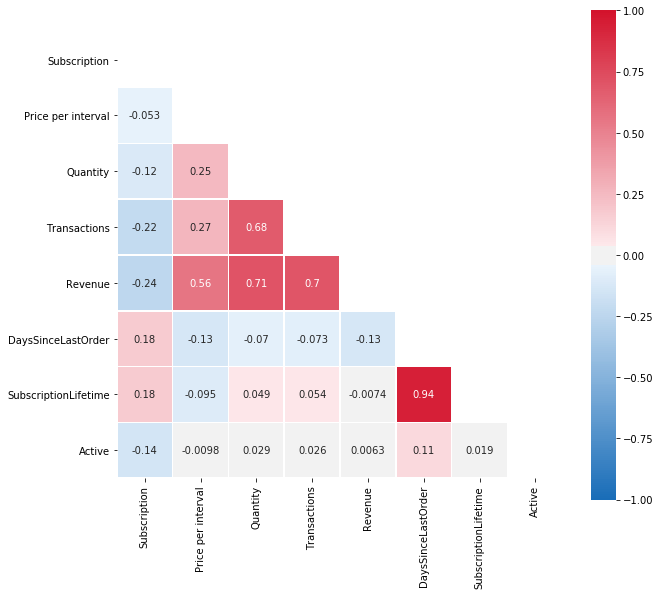

In [35]:
# Create correlation heatmap
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(250, 10, s=95, l=45,n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,square=True, linewidths=.5, 
                cbar_kws={"shrink": .9}, annot=True)

The next step is to pick only the columns that we decided to keep as well as separating the data to predictor (x) and response (y) variables. 

In [36]:
# Identify low cariance to avoid noise
low_variance = []
for col in data._get_numeric_data():
    minimum = min(data[col])
    ninety_perc = np.percentile(data[col],90)
    if ninety_perc == minimum:
        low_variance.append(col)
print(low_variance)
# data.drop(low_variance, axis=1)

['Transactions', 'Active']


Which columns do we drop?
* The `ID` column contains a unique identifier for each row and will not be useful for prediction.
* The `StopReason` & `StopReasonExtraMessage` columns contains highly detailed information. To use this information, we will need to generate dummy variables from this column. We might be creating too many dummy variables by using this column. Our goal is not to create an overcomplicated model. Therefore, we will most likely not be using the information in this column (unless our model proves to be very inaccurate without this information).
* Almost all customers that purchased are from The Netherlands. As this will not add value to our prediction, we will drop `Country`.
* As `CodeUsed` is dependent on marketing activities, we will drop this column.
* There seems to be a close relationship between `Receny` and `SubscriptionLifetime`. However, we are not dropping either because both are used in the RFM framework later on.
* There seems to be a close relationship between `Monetary` and `Quantity`. We should consider dropping one of those columns as well.
* `Transactions` and `Active` have a low variance. As `Transactions` is one of the main important variables and `Active` is our outcome variable, we decide not to drop them. 

In [37]:
# Drop unnecessary columns - Data
drop_cols = ["CodeUsed","Country","StopReason","StopReasonExtraMessage","Quantity"]
data.drop(drop_cols, axis=1, inplace=True)
data.shape

(945, 13)

In [38]:
data.head(1)

,ID,Subscription,Refill,Interval,Price per interval,PaymentMethod,Products,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,Active,SubscriptionLifetimeBin
0,2092329948149575290,1,0,3,5.0,ideal,Brush,1,54.0,217,217,0,High


The next step in our data processing is to convert the categorical variables to dummy variables using the get_dummies function. We use the get dummies function on the response variables to convert them from categorical values to a variable containing zeros and ones. We use the drop_first option to ensure that we only get one column (since for n values, the drop_first option will create n-1 variable).

In [39]:
data.head(1)

,ID,Subscription,Refill,Interval,Price per interval,PaymentMethod,Products,Transactions,Revenue,DaysSinceLastOrder,SubscriptionLifetime,Active,SubscriptionLifetimeBin
0,2092329948149575290,1,0,3,5.0,ideal,Brush,1,54.0,217,217,0,High


In [40]:
data.dtypes

ID                           object
Subscription                  int64
Refill                       object
Interval                     object
Price per interval          float64
PaymentMethod                object
Products                     object
Transactions                  int64
Revenue                     float64
DaysSinceLastOrder            int64
SubscriptionLifetime          int64
Active                        int64
SubscriptionLifetimeBin    category
dtype: object

You can see that we dropped a few columns and added a few colums because we created dummies for each unique value.

In [41]:
# Now that we have a cleaner dataset let's save a new csv
data.to_csv("../data/data_prediction.csv",index=False)